# USNCCM15 Short Course
# SC15-005: Recent Advances in Physics-Informed Deep Learning

# Hands-on tutorial on Physics-Informed Deep Generative Models
## Instructor: Paris Perdikaris, pgp@seas.upenn.edu
## Code repository: https://github.com/PredictiveIntelligenceLab/USNCCM15-Short-Course-Recent-Advances-in-Physics-Informed-Deep-Learning

# Recap on Physics-informed neural network (PINNs):
Consider the problem: 
\begin{align}
u_t + \mathcal{N}_{x}u = 0,
\end{align}
where $u(x,t)$ is represented by a deep neural network parametrized by a set of parameters $\theta$, i.e. $u(x,t) = f_{\theta}(x,t)$, $x$ is a vector of space coordinates, $t$ is the time coordinate, and $\mathcal{N}_{x}$ is a nonlinear differential operator. As neural networks are differentiable representations, this construction defines a so-called {\em physics informed neural network} that corresponds to the PDE residual, i.e. $r_{\theta}(x,t):= \frac{\partial}{\partial t} f_{\theta}(x,t)  + \mathcal{N}_{x}f_{\theta}(x,t)$. This new network has the same parameters as the network representing $u(x,t)$, albeit different activation functions due to the action of the differential operator.

The resulting training procedure allows us to recover the shared network parameters $\theta$ using a few scattered observations of $u(x,t)$, namely $\{(x_{i}, t_i), u_i\}$, $i = 1,\dots,N_u$, along with a larger number of collocation points $\{(x_{i}, t_i), r_i\}$, $i = 1,\dots,N_r$, that aim to penalize the PDE residual at a finite set of $N_r$ collocation nodes. 
\com{The data for the residual are typically zero (i.e. $r_i=0$), or they may correspond to external forcing terms evaluated at the corresponding location $(x_{i}, t_i)$, $i=1,\dots,N_r$.

The loss function follows:
\begin{align}
\mathcal{L}(\theta) = \frac{1}{N_u}\sum\limits_{i=1}^{N_u}\|f_{\theta}(x_{i}, t_i) - u_i\|^2  +   \frac{1}{N_r}\sum\limits_{i=1}^{N_r}\|r_{\theta}(x_{i}, t_i) - r_i\|^2, 
\end{align}
where the required gradients $\frac{\partial \mathcal{L}}{\partial \theta}$ can be readily obtained using automatic differentiation.

#### Raissi, M., P. Perdikaris, and G. E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational Physics 378 (2019): 686-707.

# Recap on Generative Adversarial Networks (GANs)

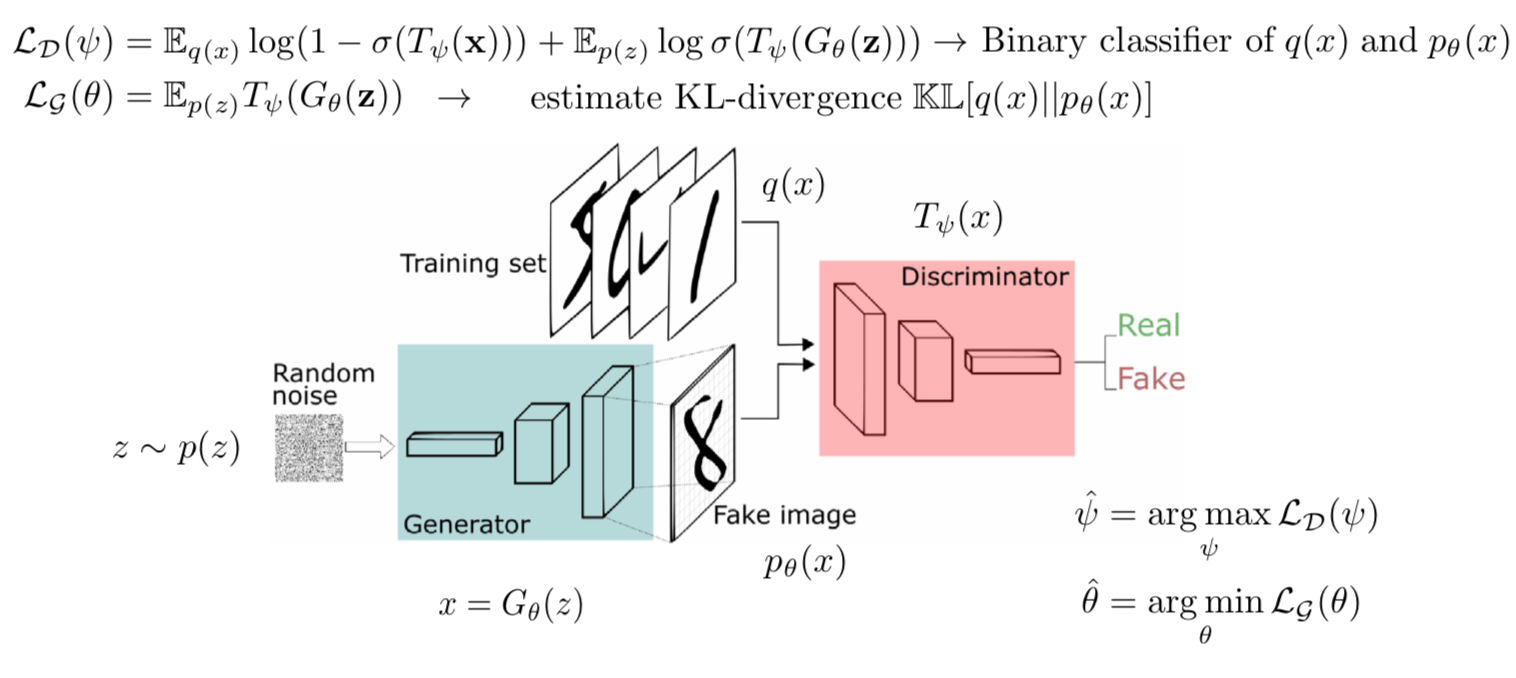

In [1]:
from IPython.display import Image
Image(filename='../images/GANs.png', width=800,height=500) 

### The density ratio  trick:
GANs rely on accurate estimation of KL-divergence: 
\begin{align}
\mathbb{KL}[p(x)||q(x)] = \int p(x)\log(\frac{p(x)}{q(x)})dx
\end{align}

However, estimating density ratios is a challenging task. 

$\bullet$ Each part of the ratio may itself involve intractable integrals.

$\bullet$ We often deal with high-dimensional quantities.

$\bullet$ We may only have samples drawn from the two distributions, not their analytical forms.

This is where the density ratio trick enters: it allows us to construct a binary classifier $T(x)$ that learns to distinguish between samples from the two distributions.
 
\begin{align}
    \frac{p(x)}{ q(x)} & = \frac{\rho(x|c=+1)}{\rho(x|c=-1)} \\
    & = \frac{\rho(c=+1|x)\rho(x)}{\rho(c=+1)} \bigg/ \frac{\rho(c=-1|x)\rho(x)}{\rho(c=-1)} \\
    & = \frac{\rho(c=+1|x)}{\rho(c=-1|x)} = \frac{\rho(c=+1|x)}{1 - \rho(c=+1|x)} \\
    & = \frac{T(x)}{1-T(x)}.
\end{align}

### But still GANs suffers from the mode collapse issue. 

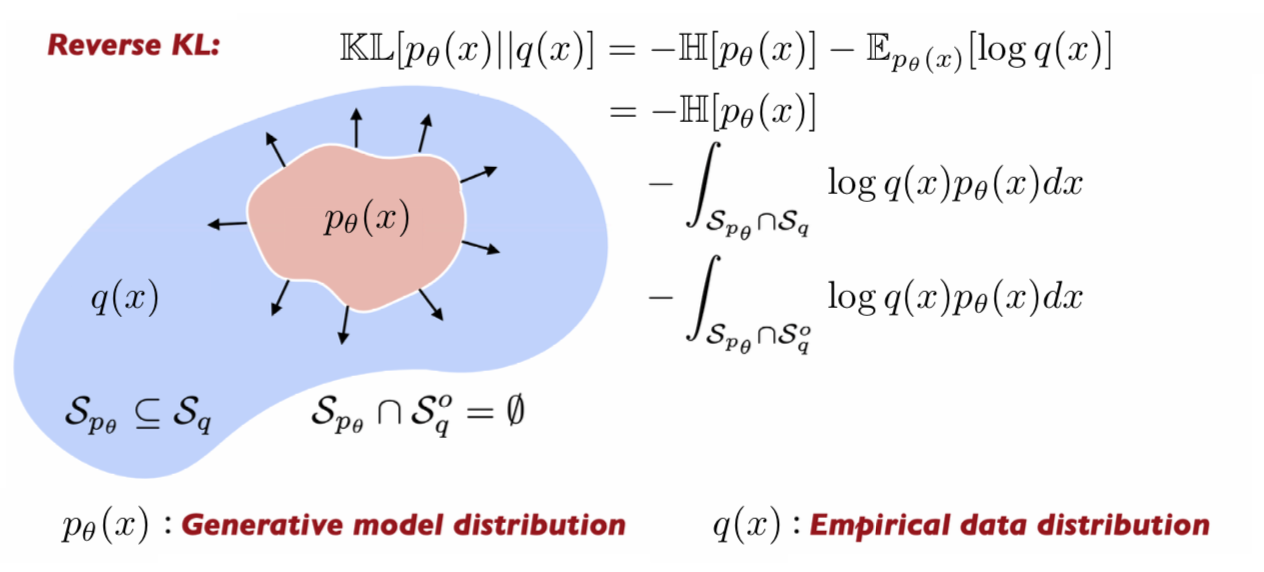

In [2]:
from IPython.display import Image
Image(filename='../images/mode_collapse.png', width=600,height=400) 

In order to tackle this issue, one can consider using the reverse KL-divergence as a training objective and introduce an entropic regularization mechanism: $-\lambda\mathbb{H}(p_{\theta}(x)) - \mathbb{E}_{p_{\theta}(x)}\log q(x)$,  instead of $\mathbb{KL}[p_{\theta}(x)||q(x)]$ with $\lambda > 1$. 

#### Li, Chunyuan, Jianqiao Li, Guoyin Wang, and Lawrence Carin. "Learning to Sample with Adversarially Learned Likelihood-Ratio." (2018).

# Physics-informed deep generative models

Our goal here is to leverage these recent development in probablistic deep learning to model stochastic processes that arise as solutions to stochastic PDEs. To this end, we extend the deterministic formulation of Physics-Informed Neural Networks (PINNs) to a probabilistic setting for propagating uncertainty through latent variable models of the form:
\begin{align}
p(u|x,t,z), \ \ z\sim p(z), \ \ \text{s.t} \ \  u_t + \mathcal{N}_{x}u = 0
\end{align}
This setting encapsulates a wide range of deterministic and stochastic problems, where $u(x,t)$ is a potentially multi-variate random field depending on spatial and temporal variables $x$ and $t$, respectively, and $z$ is a collection of random latent variables with a prior distribution $p(z)$. 

To train such models from data (i.e., initial and/or boundary data plus collocation points for minimizing the PDE residual), we can formulate an adversarial game for training 3 deep neural networks: (i) a generator $f_{\theta}(x,t,z)$, (ii) a discriminator $T_{\psi}(x,t,u)$, and (iii) an encoder $q_{\phi}(z|x,t,u)$. The role of the generator is to learn how to produce faithful samples from the true underlying distribution $p(x,t,u)$ such that those samples approximately satisfy the underlying PDE. The role of the discriminator is learn how distinguish between samples produced by the generative model distribution $p_{\theta}(x,t,u)$ and samples originating from the empirical distribution of the observed data $q(x,t,u)$, thus yielding an approximation of the reverse KL-divergence between $p_{\theta}$ and $q$ via the density ratio trick. Last, the goal of the encoder $q_{\phi}(z|x,t,u)$ is to introduce an entropic regularization mechanism for mitigating the issue of mode collapse, as well as to recover an approximate posterior distribution over the latent variables $z$.

Putting all the pieces together, we can derive an adversarial training rule for updating the unkown model parameters contained in the vectors $\theta,\phi$ and $\psi$ as:
\begin{align}
    \mathcal{L}_{PDE}(\theta) = \frac{1}{N_r}\sum_{i=1}^{N_r}\|r_{\theta}(x_i, t_i)\|^2.
\end{align}
with
\begin{align}
	\mathcal{L}_{\mathcal{D}}(\psi) = & \  \mathbb{E}_{q(x,t)p(z)}[\log\sigma(T_{\psi}(x,t,f_{\theta}(x,t,z)))] + \\ & \ \mathbb{E}_{q(x,t,u)}[\log(1-\sigma(T_{\psi}(x,t,u)))],\\
	\mathcal{L}_{\mathcal{G}}(\theta, \phi) = & \ \mathbb{E}_{q(x,t)p(z)}[T_{\psi}(x, t, f_{\theta}(x,t,z))\\
	&+ (1-\lambda)\log(q_{\phi}(z|x,t,f_{\theta}(x,t,z)))],
\end{align}
Then, the resulting adversarial game for training the physics-informed deep generative model takes the form:
\begin{align}
    & \mathop{\max}_{\psi} \ \mathcal{L}_{\mathcal{D}}(\psi)\\
    & \mathop{\min}_{\theta, \phi} \ \mathcal{L}_{\mathcal{G}}(\theta, \phi) + \mathcal{L}_{PDE}(\theta),
\end{align}

# Tensorflow Implementation
All elements defining our physics-informed deep generative model implementation can be summarized in the following Tensorflow class.

In [3]:
import tensorflow as tf
import numpy as np
import timeit
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from plotting import newfig, savefig
import time
from tqdm import tqdm
from scipy import stats

np.random.seed(1234)

/Users/paris/tensorflow/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [4]:
# Define the model class
# Model class takes the intput:
# X_f: collocation points in [-1, 1], X_u: positions on the boundary (in this case -1 and 1), 
# Y_u: data on the boundary (in this case, boundary conditions), layers_P: network structure of generator,
# layers_Q: network structure of encoder, layers_T: network structure of discriminator,
# lam: entropic regularization coefficient, beta: physics-informed regularization

class PIDGM:
    # Initialize the class
    def __init__(self, X_r, X_u, Y_u, layers_P, layers_Q, layers_T, lam = 1.0, beta = 1.0): 
        # X_f: collocation points, X_u: input data X, Y_u: output data Y,
        # layers_P: decoder network structure, layers_Q: encoder network structure, layers_T: discriminator network structure,
        # lam: entropic regularization parameter, beta: physics-informed regularization parameter
                
        # Normalize data
        self.Xmean, self.Xstd = X_r.mean(0), X_r.std(0)
        self.Ymean, self.Ystd = Y_u.mean(0), Y_u.std(0)
        X_r = (X_r - self.Xmean) / self.Xstd
        X_u = (X_u - self.Xmean) / self.Xstd
        # Jacobian with respect to the normalization
        self.Jacobian = 1 / self.Xstd
        
        # Normalized and collocation points and training input, output data
        self.X_r = X_r
        self.X_u = X_u
        self.Y_u = Y_u
        
        # Neural network structures
        self.layers_P = layers_P
        self.layers_Q = layers_Q
        self.layers_T = layers_T
        
        # Input, output and latent variable dimensions
        self.X_dim = X_u.shape[1]
        self.Y_dim = Y_u.shape[1]
        self.Z_dim = layers_Q[-1]
        
        # Regularization parameters
        self.lam = lam
        self.beta = beta
        
        # Ratio of training for generator and discriminator in each iteration: k1 for discriminator, k2 for generator
        self.k1 = 1
        self.k2 = 5

        # Initialize network weights and biases        
        self.weights_P, self.biases_P = self.initialize_NN(layers_P)
        self.weights_Q, self.biases_Q = self.initialize_NN(layers_Q)
        self.weights_T, self.biases_T = self.initialize_NN(layers_T)
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        
        # Define placeholders and computational graph
        self.X_u_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.X_r_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.Y_u_tf = tf.placeholder(tf.float32, shape=(None, self.Y_dim))
        self.Z_u_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))
        self.Z_r_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))

        # Predict output
        self.Y_u_pred = self.net_P(self.X_u_tf, self.Z_u_tf)
        # Predict the residual at collocation points
        self.Y_r_pred = self.get_r(self.X_r_tf, self.Z_r_tf)

        # Generator loss (to be minimized)
        self.G_loss, self.KL_loss, self.recon_loss, self.PDE_loss  = self.compute_generator_loss(self.X_u_tf, self.Y_u_tf, self.Y_u_pred,
                                                                        self.X_r_tf, self.Y_r_pred, self.Z_u_tf, self.Z_r_tf)
                                                
        # Discriminator loss (to be minimized)
        self.T_loss  = self.compute_discriminator_loss(self.X_u_tf, self.Y_u_tf, self.Z_u_tf)
        
        # Generate samples of y given x by sampling from latent space
        self.sample = self.sample_generator(self.X_u_tf, self.Z_u_tf)
        
        # Define optimizer  with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                   1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op_KL = tf.train.AdamOptimizer(self.learning_rate).minimize(self.G_loss,
                                                                               var_list = [self.weights_P, self.biases_P,
                                                                                           self.weights_Q, self.biases_Q],
                                                                               global_step=self.global_step)        
        # Passing global_step to minimize() will increment it at each step.
        self.train_op_T = tf.train.AdamOptimizer(self.learning_rate).minimize(self.T_loss,
                                                                               var_list = [self.weights_T, self.biases_T],
                                                                               global_step=self.global_step)

        # Logger
        self.loss_G_log = []
        self.loss_T_log = []
        self.loss_KL_log = []
        self.loss_recon_log = []
        self.loss_PDE_log = []
        self.saver = tf.train.Saver()
        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
           
           
    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    # Forcing term (right hand of the ODE)
    def f(self, X_normalized): #
        X = self.Xstd * X_normalized + self.Xmean
        return - np.pi ** 2 * tf.sin(np.pi*X) - np.pi * tf.cos(np.pi * X) * tf.sin(np.pi * X) ** 2
    
    # Decoder: p(y|x,z)
    def net_P(self, X, Z):
        Y = self.forward_pass(tf.concat([X, Z], 1),
                              self.layers_P,
                              self.weights_P,
                              self.biases_P)
        return Y
    
    # Encoder: q(z|x,y)
    def net_Q(self, X, Y):
        Z = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_Q,
                              self.weights_Q,
                              self.biases_Q)
        return Z
    
    # Discriminator
    def net_T(self, X, Y):
        T = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_T,
                              self.weights_T,
                              self.biases_T)        
        return T
    
    # Physics-Informed neural network prediction
    def get_u(self, X, Z):
        z_prior = Z       
        u = self.net_P(X, z_prior)
        return u

    # Physics-Informed residual on the collocation points
    def get_r(self, X, Z):
        z_prior = Z    
        u = self.net_P(X, z_prior)
        u_x = tf.gradients(u, X)[0]
        u_xx = tf.gradients(u_x, X)[0]
        f = self.f(X)
        r = (self.Jacobian ** 2) * u_xx - (self.Jacobian) * (u ** 2) *u_x - f
        return r    
    
    # Compute the generator loss
    def compute_generator_loss(self, X_u, Y_u, Y_u_pred, X_r, Y_r_pred, Z_u, Z_r):  
        # Prior: z_u for input data, z_f for collocation points
        z_u_prior = Z_u
        z_r_prior = Z_r
        # Encoder: q(z|x,y)
        z_u_encoder = self.net_Q(X_u, Y_u_pred)
        z_r_encoder = self.net_Q(X_r, Y_r_pred)
        # Discriminator loss
        Y_pred = self.net_P(X_u, Z_u)
        T_pred = self.net_T(X_u, Y_pred)
        
        # KL-divergence between the data distribution and the model distribution
        KL = tf.reduce_mean(T_pred)

        # Entropic regularization
        log_q = - tf.reduce_mean(tf.square(z_u_prior-z_u_encoder))
        
        # Physics-informed loss
        loss_f = tf.reduce_mean(tf.square(Y_r_pred))

        # Generator loss
        loss = KL + (1.0-self.lam)*log_q + self.beta * loss_f
        
        return loss, KL, (1.0-self.lam)*log_q, self.beta * loss_f
    
    # Compute the discriminator loss
    def compute_discriminator_loss(self, X, Y, Z): 
        # Prior: p(z)
        z_prior = Z
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)                
        
        # Discriminator loss
        T_real = self.net_T(X, Y)
        T_fake = self.net_T(X, Y_pred)
        
        T_real = tf.sigmoid(T_real)
        T_fake = tf.sigmoid(T_fake)
        
        T_loss = -tf.reduce_mean(tf.log(1.0 - T_real + 1e-8) + \
                                 tf.log(T_fake + 1e-8)) 
        
        return T_loss
           
    
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, Y, N_batch):
        N = X.shape[0]
        idx = np.random.choice(N, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]
        return X_batch, Y_batch
    
    
    # Trains the model with mini-batch stochastic gradient descent
    def train(self, nIter = 20000, N_u = 2, N_r = 100): 

        start_time = timeit.default_timer()
        for it in tqdm(range(nIter)):     

            # Sampling from the latent space for data and collocation points
            Z_u = np.random.randn(N_u, self.Z_dim)
            Z_r = np.random.randn(N_r, self.Z_dim)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.X_u_tf: self.X_u, self.Y_u_tf: self.Y_u, self.X_r_tf: self.X_r,
                       self.Z_u_tf: Z_u, self.Z_r_tf: Z_r}  
            
            # Run the Tensorflow session to minimize the loss
            for i in range(self.k1):
                self.sess.run(self.train_op_T, tf_dict)
            for j in range(self.k2):
                self.sess.run(self.train_op_KL, tf_dict)
        
            # Print
            if it % 50 == 0:
#                 elapsed = timeit.default_timer() - start_time
                loss_G_value, loss_T_value, loss_KL_value, loss_recon_value, loss_PDE_value = self.sess.run([self.G_loss, 
                                                                                                             self.T_loss, 
                                                                                                             self.KL_loss, 
                                                                                                             self.recon_loss, 
                                                                                                             self.PDE_loss], tf_dict)
                self.loss_G_log.append(loss_G_value)
                self.loss_T_log.append(loss_T_value)
                self.loss_KL_log.append(loss_KL_value)
                self.loss_recon_log.append(loss_recon_value)
                self.loss_PDE_log.append(loss_PDE_value)                
#                 print('It: %d, KL_loss: %.2e, Recon_loss: %.2e, PDE_loss: %.2e, T_loss: %.2e, Time: %.2f' % 
#                       (it, loss_KL_value, reconv, loss_PDE, loss_T_value, elapsed))
#                 start_time = timeit.default_timer()
                
    # Generate samples of y given x by sampling from the latent space z
    def sample_generator(self, X, Z):        
        # Prior:
        z_prior = Z       
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)      
        return Y_pred

    # Predict y given x
    def generate_sample(self, X_star):
        # Normalize the input data
        X_star = (X_star - self.Xmean) / self.Xstd
        Z = np.random.randn(X_star.shape[0], self.Z_dim)
        tf_dict = {self.X_u_tf: X_star, self.Z_u_tf: Z}       
        Y_star = self.sess.run(self.sample, tf_dict) 
        Y_star = Y_star 
        return Y_star

# Example simulation

Now we are ready to set up and train our first physics-informed deep generative model.

We illustrate the basic capabilities of the proposed workflow through a simple one-dimensional differential equation taking the form: 
\begin{align}
	&u_{xx} - u^2u_x = f(x), \quad\quad x\in[-1, 1], \\
	&f(x) = -\pi^2\sin(\pi x) - \pi\cos(\pi x)\sin^2(\pi x),\\
\end{align}
with the choice of $f(x)$, the solution of this problem is: $u(x) = sin(\pi x)$. 

Stochasticity is introduced by perturbing the boundary conditions by Gaussian noise, i.e.,
$$u(-1), u(1)\sim \mathcal{N}(0, \sigma_n^2), \ \ \text{with} \ \ \sigma_n = 0.05.$$

In [5]:
# Number of collocation points to minimize the PDE residual
N_r = 100

# Number of test points for validating and plotting the prediction
N_ref = 200

# Number of the training data corresponding to different realizations of the boundary conditions
N_u = 20

# Define the input, output, latent variable dimension
X_dim = 1
Y_dim = 1
Z_dim = 1

# Define noise level for the boundary condition perturbation
noise_level = 0.05

# Reference solution of the deterministic problem (i.e. the case with \sigma_n^2 = 0)
def f(X):
    return np.sin(np.pi * X)

# Position of the collocation points
X_r = np.linspace(-1.,1.,N_r)[:,None]

# Position of the boundary conditions
X_ut = np.linspace(-1.,1.,2)[:,None]
X_u = X_ut
for i in range(N_u-1):
    X_u = np.vstack((X_u, X_ut))

# Generate stochastic boundary condition
Y_ut = f(X_ut)
Y_u = Y_ut + noise_level * np.random.randn(2, Y_dim)
for i in range(N_u-1):
    Y_ut = noise_level * np.random.randn(2, Y_dim)
    Y_u = np.vstack((Y_u, Y_ut))

# Reference solution on the testing points
X_ref = np.linspace(-1.,1.,N_ref)[:,None]
Y_ref = f(X_ref)

# Load the reference solution generated by Monte Carlo (used for validation purposes)
data = scipy.io.loadmat('../data/ODE2000.mat')
Exact = np.real(data['U']).T

In [6]:
# Fully-connected neural net architectures (dimensions of each layer)
layers_P = np.array([X_dim+Z_dim,50,50,50,50,Y_dim])     # Generator
layers_Q = np.array([X_dim+Y_dim,50,50,50,50,Z_dim])     # Encoder
layers_T = np.array([X_dim+Y_dim,50,50,1])               # Discriminator

# Define the model
model = PIDGM(X_r, X_u, Y_u, layers_P, layers_Q, layers_T, lam = 1.5, beta = 1.)

W0725 12:36:29.755733 4820297152 deprecation.py:323] From /Users/paris/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# Load stored model
model.saver.restore(model.sess, "../SavedModels/PIDGM_example1D.ckpt")

# Train the model
model.train(nIter = 10000, N_u = 2*N_u, N_r = N_r)

W0725 12:36:30.584928 4820297152 deprecation.py:323] From /Users/paris/tensorflow/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
100%|██████████| 10000/10000 [03:16<00:00, 50.86it/s]


In [8]:
# Compute prediction using Monte Carlo sampling of the trained model
N_samples = 5000
samples_mean = np.zeros((X_ref.shape[0], N_samples))
for i in range(0, N_samples):
    samples_mean[:,i:i+1] = model.generate_sample(X_ref)

# Compute the mean and the variance of the prediction at randomly selected points in the domain
mu_pred = np.mean(samples_mean, axis = 1)    
Sigma_pred = np.var(samples_mean, axis = 1)

# Compute the prediction relative error agaisnt the determinisic mean
error_u = np.linalg.norm(Y_ref-mu_pred[:,None],2)/np.linalg.norm(Y_ref,2)
print('Error u: %e' % (error_u))

Error u: 1.925153e-02


W0725 12:39:49.283022 4820297152 font_manager.py:1282] findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


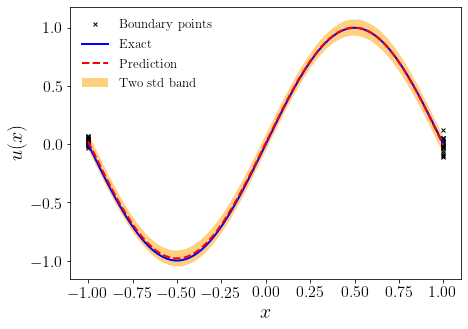

W0725 12:39:51.292705 4820297152 font_manager.py:1282] findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


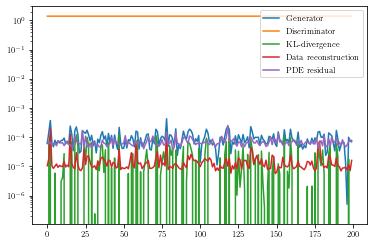

In [9]:
# Plot the prediction with the uncertainty versus the reference solution
ax = plt.figure(1,figsize=(7,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(X_u, Y_u, 'kx', markersize = 4, label = "Boundary points")
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x)$',fontsize=20)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
ax.plot(model.loss_G_log, label = 'Generator')
ax.plot(model.loss_T_log, label = 'Discriminator')
ax.plot(model.loss_KL_log, label = 'KL-divergence')
ax.plot(model.loss_recon_log, label = 'Data reconstruction')
ax.plot(model.loss_PDE_log, label = 'PDE residual')
ax.set_yscale('log')
plt.legend(loc='upper right')

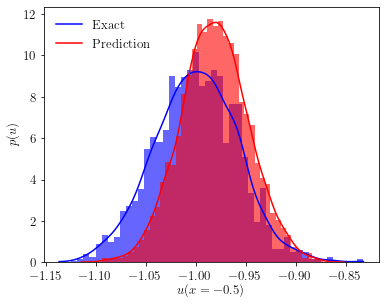

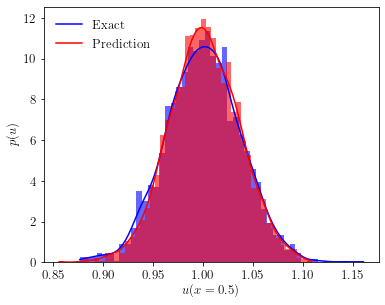

In [10]:
######### Compare the uncertainty at x = -0.5 and x = 0.5 ########

# E1 and E3 represent the samples of reference solution at x = -0.5 and x = 0.5
E1 = Exact[50,:][:, None]
E3 = Exact[150,:][:, None]

# M1 and M3 represent the samples of our generative model at x = -0.5 and x = 0.5
M1 = samples_mean[50,:][:, None]
M3 = samples_mean[150,:][:, None]


######## Probability density kernel estimation ########

# Kernel density estimation of reference solution at x = -0.5
xmin, xmax = E1.min(), E1.max()
X_marginal_1 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_1 = X_marginal_1.flatten()
values_marginal_1 = E1.flatten()
gkde = stats.gaussian_kde(values_marginal_1)
KDE_marginal_1 = gkde.evaluate(positions_marginal_1)

# Kernel density estimation of reference solution at x = 0.5
xmin, xmax = E3.min(), E3.max()
X_marginal_3 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_3 = X_marginal_3.flatten()
values_marginal_3 = E3.flatten()
gkde = stats.gaussian_kde(values_marginal_3)
KDE_marginal_3 = gkde.evaluate(positions_marginal_3)

# Kernel density estimation of generative model solution at x = -0.5
xmin, xmax = M1.min(), M1.max()
X_marginal_4 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_4 = X_marginal_4.flatten()
values_marginal_4 = M1.flatten()
gkde = stats.gaussian_kde(values_marginal_4)
KDE_marginal_4 = gkde.evaluate(positions_marginal_4)

# Kernel density estimation of generative model solution at x = 0.5
xmin, xmax = M3.min(), M3.max()
X_marginal_6 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_6 = X_marginal_6.flatten()
values_marginal_6 = M3.flatten()
gkde = stats.gaussian_kde(values_marginal_6)
KDE_marginal_6 = gkde.evaluate(positions_marginal_6)


# Comparion of the probability density of the reference solution and our model solution at x = -0.5
ax = plt.figure(3,figsize=(6,4.7))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.hist(Exact[50,:], bins = 50, density=True, alpha = 0.6, color='blue')
plt.hist(samples_mean[50,:], bins = 50, density=True, alpha = 0.6, color='red')
plt.plot(X_marginal_1, KDE_marginal_1, 'b-', label = 'Exact')
plt.plot(X_marginal_4, KDE_marginal_4, 'r-', label = 'Prediction')
plt.xlabel('$u(x = - 0.5)$',fontsize=13)
plt.ylabel('$p(u)$',fontsize=13)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

# Comparion of the probability density of the reference solution and our model solution at x = 0.5
ax = plt.figure(5,figsize=(6,4.7))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.hist(Exact[150,:], bins = 50, density=True, alpha = 0.6, color='blue')
plt.hist(samples_mean[150,:], bins = 50, density=True, alpha = 0.6, color='red')
plt.plot(X_marginal_3, KDE_marginal_3, 'b-', label = 'Exact')
plt.plot(X_marginal_6, KDE_marginal_6, 'r-', label = 'Prediction')
plt.xlabel('$u(x = 0.5)$',fontsize=13)
plt.ylabel('$p(u)$',fontsize=13)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

In [11]:
# Save model
model.saver.save(model.sess, "../SavedModels/PIDGM_example1D.ckpt")

'../SavedModels/PIDGM_example1D.ckpt'